#### Import libraries

In [1]:

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from matplotlib import pyplot as plt


#### Show installed GPUs.

In [2]:

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    print("Name: ", gpu.name, " Type: ", gpu.device_type)


Name:  /physical_device:GPU:0  Type:  GPU


#### Load the dataset.

In [3]:

df = pd.read_csv('../dataset/preprocessed-sam-dataset.csv', sep='|',
                 dtype = {'Fp1': 'float64', 'FC5': 'float64', 'T7': 'float64',
                          'O2': 'float64', 'P4': 'float64', 'F8': 'float64',
                          'Scale': 'int8'})


#### Display the dataset size.

In [4]:
df.shape

(140800, 7)

#### Instantiate and train a MLP model with the same configuration as the model used in the original project.

- 5-layer architecture (100, 300, 500, 300 and 100 units).
- Data augmentation (30x).
- Dataset with 6 features after feature selection (less than original project).

In [5]:

def create_baseline() :
    model = Sequential()
    model.add(Dense(100, input_shape = (6,), activation = 'relu'))
    model.add(Dense(300, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(300, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model


# Data augmentation (30x).
print("\nStarting data augmentation.")
df_list = []
for count in range(0, 11) :
    df_list.append(df[df.iloc[:, 6] == count])
df_result = pd.DataFrame(columns = ['Fp1', 'FC5', 'T7', 'O2', 'P4', 'F8', 'Scale'])
for count in range(0, 11) :
    df_upsampled = resample(df_list[count], replace = True, n_samples = 384000, stratify = df_list[count])
    df_result = pd.concat([df_result, df_upsampled])
print("\nDataset shape: {}".format(df_result.shape))
print(df_result.Scale.value_counts())


# Split dataset (training and test sets) and scale data.
print("\nSplitting and scalling data")
X = df_result.drop('Scale', axis = 1)
y = df_result['Scale'].astype('int8') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

scaler = StandardScaler()
scaled_trainX = scaler.fit_transform(X_train)
scaled_testX = scaler.transform(X_test)


# Train the MLP model and evaluate it.
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 10)
model = create_baseline()
history = model.fit(scaled_trainX, y_train, validation_split = 0.1, epochs = 300, batch_size = 512, verbose = 1, callbacks = [es])

_, train_accuracy = model.evaluate(scaled_trainX, y_train, verbose = 0)
_, test_accuracy = model.evaluate(scaled_testX, y_test, verbose = 0)

print("\nTrain Accuracy: {:.4f} %".format(train_accuracy))
print("Test Accuracy: {:.4f} %".format(test_accuracy))



Starting data augmentation.

Dataset shape: (4224000, 7)
0     384000
1     384000
2     384000
3     384000
4     384000
5     384000
6     384000
7     384000
8     384000
9     384000
10    384000
Name: Scale, dtype: int64

Splitting and scalling data
Epoch 1/300
5198/5198 [==============================] - 21s 4ms/step - loss: 2.3357 - accuracy: 0.1494 - val_loss: 2.2834 - val_accuracy: 0.1782
Epoch 2/300
5198/5198 [==============================] - 25s 5ms/step - loss: 2.1533 - accuracy: 0.2355 - val_loss: 2.0041 - val_accuracy: 0.2962
Epoch 3/300
5198/5198 [==============================] - 26s 5ms/step - loss: 1.8097 - accuracy: 0.3715 - val_loss: 1.6742 - val_accuracy: 0.4213
Epoch 4/300
5198/5198 [==============================] - 26s 5ms/step - loss: 1.4903 - accuracy: 0.4878 - val_loss: 1.3873 - val_accuracy: 0.5244
Epoch 5/300
5198/5198 [==============================] - 26s 5ms/step - loss: 1.2467 - accuracy: 0.5740 - val_loss: 1.1984 - val_accuracy: 0.5902
Epoch 6/300
51

5198/5198 [==============================] - 41s 8ms/step - loss: 0.1863 - accuracy: 0.9434 - val_loss: 0.1570 - val_accuracy: 0.9519
Epoch 56/300
5198/5198 [==============================] - 33s 6ms/step - loss: 0.1778 - accuracy: 0.9460 - val_loss: 0.1940 - val_accuracy: 0.9412
Epoch 57/300
5198/5198 [==============================] - 33s 6ms/step - loss: 0.1805 - accuracy: 0.9453 - val_loss: 0.1564 - val_accuracy: 0.9519
Epoch 58/300
5198/5198 [==============================] - 32s 6ms/step - loss: 0.1750 - accuracy: 0.9468 - val_loss: 0.1857 - val_accuracy: 0.9434
Epoch 59/300
5198/5198 [==============================] - 33s 6ms/step - loss: 0.1775 - accuracy: 0.9466 - val_loss: 0.1744 - val_accuracy: 0.9469
Epoch 60/300
5198/5198 [==============================] - 34s 6ms/step - loss: 0.1705 - accuracy: 0.9486 - val_loss: 0.1805 - val_accuracy: 0.9443
Epoch 61/300
5198/5198 [==============================] - 34s 7ms/step - loss: 0.1704 - accuracy: 0.9484 - val_loss: 0.1693 - val_a

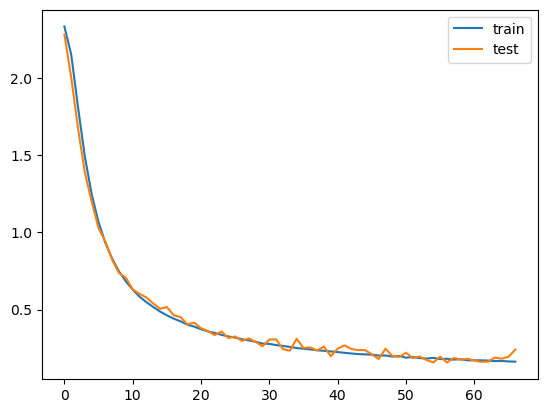

In [6]:

# Plot loss history
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()


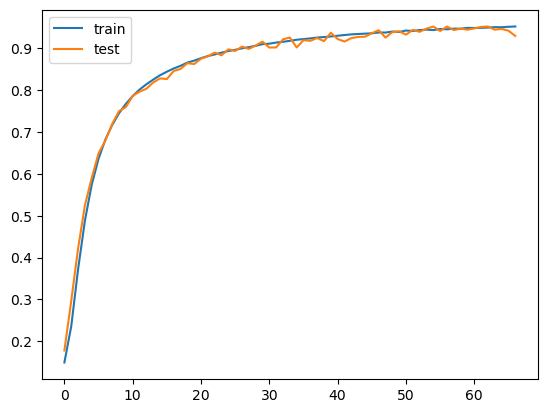

In [9]:

# Plot accuracy history
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "test")
plt.legend()
plt.show()


#### Tunning the MLP model.

- Setting the parameter kernel_initializer = "he_uniform".

In [5]:

def create_v1() :
    model = Sequential()
    model.add(Dense(100, input_shape = (6,), activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(300, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(500, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(300, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(100, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model


# Data augmentation (30x).
print("\nStarting data augmentation.")
df_list = []
for count in range(0, 11) :
    df_list.append(df[df.iloc[:, 6] == count])
df_result = pd.DataFrame(columns = ['Fp1', 'FC5', 'T7', 'O2', 'P4', 'F8', 'Scale'])
for count in range(0, 11) :
    df_upsampled = resample(df_list[count], replace = True, n_samples = 384000, stratify = df_list[count])
    df_result = pd.concat([df_result, df_upsampled])
print("\nDataset shape: {}".format(df_result.shape))
print(df_result.Scale.value_counts())


# Split dataset (training and test sets) and scale data.
print("\nSplitting and scalling data")
X = df_result.drop('Scale', axis = 1)
y = df_result['Scale'].astype('int8') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

scaler = StandardScaler()
scaled_trainX = scaler.fit_transform(X_train)
scaled_testX = scaler.transform(X_test)


# Train the MLP model and evaluate it.
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 10)
model = create_v1()
history = model.fit(scaled_trainX, y_train, validation_split = 0.1, epochs = 300, batch_size = 512, verbose = 1, callbacks = [es])

_, train_accuracy = model.evaluate(scaled_trainX, y_train, verbose = 0)
_, test_accuracy = model.evaluate(scaled_testX, y_test, verbose = 0)

print("\nTrain Accuracy: {:.4f} %".format(train_accuracy))
print("Test Accuracy: {:.4f} %".format(test_accuracy))



Starting data augmentation.

Dataset shape: (4224000, 7)
0     384000
1     384000
2     384000
3     384000
4     384000
5     384000
6     384000
7     384000
8     384000
9     384000
10    384000
Name: Scale, dtype: int64

Splitting and scalling data
Epoch 1/300
5198/5198 [==============================] - 32s 6ms/step - loss: 2.3307 - accuracy: 0.1524 - val_loss: 2.2550 - val_accuracy: 0.1918
Epoch 2/300
5198/5198 [==============================] - 27s 5ms/step - loss: 2.0789 - accuracy: 0.2682 - val_loss: 1.8875 - val_accuracy: 0.3429
Epoch 3/300
5198/5198 [==============================] - 26s 5ms/step - loss: 1.6642 - accuracy: 0.4267 - val_loss: 1.5022 - val_accuracy: 0.4825
Epoch 4/300
5198/5198 [==============================] - 26s 5ms/step - loss: 1.3269 - accuracy: 0.5460 - val_loss: 1.2312 - val_accuracy: 0.5793
Epoch 5/300
5198/5198 [==============================] - 27s 5ms/step - loss: 1.0929 - accuracy: 0.6263 - val_loss: 1.0299 - val_accuracy: 0.6474
Epoch 6/300
51

5198/5198 [==============================] - 32s 6ms/step - loss: 0.1914 - accuracy: 0.9402 - val_loss: 0.1794 - val_accuracy: 0.9436
Epoch 56/300
5198/5198 [==============================] - 33s 6ms/step - loss: 0.1913 - accuracy: 0.9403 - val_loss: 0.2149 - val_accuracy: 0.9323
Epoch 57/300
5198/5198 [==============================] - 34s 7ms/step - loss: 0.1877 - accuracy: 0.9414 - val_loss: 0.1529 - val_accuracy: 0.9516
Epoch 58/300
5198/5198 [==============================] - 35s 7ms/step - loss: 0.1864 - accuracy: 0.9419 - val_loss: 0.2365 - val_accuracy: 0.9284
Epoch 59/300
5198/5198 [==============================] - 35s 7ms/step - loss: 0.1847 - accuracy: 0.9426 - val_loss: 0.1731 - val_accuracy: 0.9460
Epoch 60/300
5198/5198 [==============================] - 36s 7ms/step - loss: 0.1811 - accuracy: 0.9438 - val_loss: 0.1724 - val_accuracy: 0.9451
Epoch 61/300
5198/5198 [==============================] - 37s 7ms/step - loss: 0.1826 - accuracy: 0.9433 - val_loss: 0.2050 - val_a

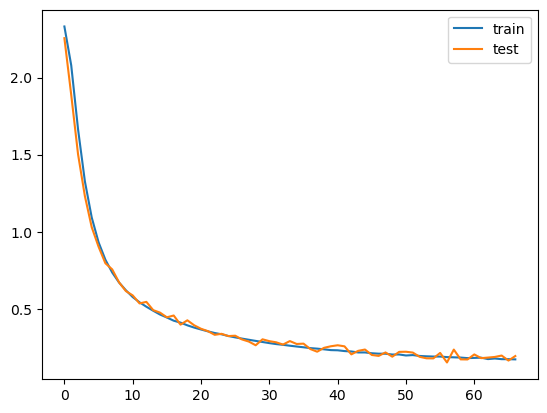

In [6]:

# Plot loss history
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()


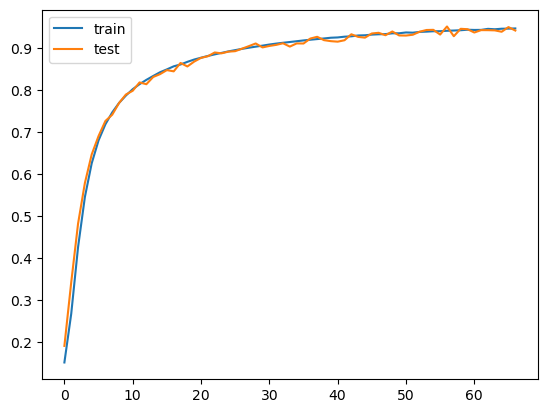

In [7]:

# Plot accuracy history
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "test")
plt.legend()
plt.show()
